In [1]:
import pandas as pd
import numpy as np

from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy import units as u
from astropy import coordinates as coord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.utils.data import get_pkg_data_filename

from urllib.request import urlretrieve

## Astropy & Fits
This notebook covers the following topics:
* Units
* Sky Coordinates and Coordinate Systems
* Reading *.fits* Files
* Skymaps
* Contours and Annotations

#### Units

In [2]:
# Specify the unit by multiplying
E = 10 * u.TeV
E

<Quantity 10. TeV>

In [3]:
# Get the particular value or unit
print('value: ', E.value)
print('unit: ', E.unit)

value:  10.0
unit:  TeV


In [4]:
# It is also possible to add a unit to arrays
Energies = np.array([10,30,42]) * u.Joule
Energies[0]

<Quantity 10. J>

In [5]:
# The units can be converted
dist = 1.0 * u.parsec
dist.to(u.km)

<Quantity 3.08567758e+13 km>

In [6]:
# Calculations with units
mass = 100000 * u.g
accel = 10.0 * u.meter / u.second**2
force = mass * accel
print(force)
print(force.to(u.Newton))

1000000.0 g m / s2
1000.0 N


In [7]:
# Units may cancel out
no_dim = 42 * u.kg / u.kg
print(no_dim)
print(no_dim.unit)

42.0



In [8]:
# Special units like magnitudes, dB etc (they are logartihmic)
-2.5 * u.mag(u.ct / u.s)

<Magnitude -2.5 mag(ct / s)>

#### Coordinates

In [9]:
# Define a coordinate
c = coord.SkyCoord(ra=23.47658*u.deg, dec=01.15342*u.deg, frame='fk5')
c

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (23.47658, 1.15342)>

In [10]:
# Transform the coordinate to Galactic coordinates
c.galactic

<SkyCoord (Galactic): (l, b) in deg
    (144.50046743, -59.92793389)>

__Side note__: Also pixel coordinates can be transformed to sky coordinates, but therefore a so-called *header* is needed, which describes the experiment / measurement setup. We'll cover that later.

In [11]:
# Define other coordinates
# Specify the units either directly with the value or as a separate statement
c1 = coord.SkyCoord('23 47 09.10 +01 15 08.56', unit=(u.hourangle, u.deg))
c2 = coord.SkyCoord('23h47m09.10s', '+01d15m08.56s')
c3 = coord.SkyCoord(23.47658, 01.15342, unit=u.deg)

In [12]:
# Access coordinate
print('RA: ', c1.ra)
print('Dec: ', c1.dec)
print('')
print('RA / h: ', c1.ra.hour)
print('RA / deg: ', c1.ra.deg)

RA:  356d47m16.5s
Dec:  1d15m08.56s

RA / h:  23.785861111111114
RA / deg:  356.78791666666666


In [13]:
# Add a distance to the coordinate
c4 = coord.SkyCoord(ra=23.47658*u.deg, dec=01.15342*u.deg, distance=555*u.Mpc)

In [14]:
# With a specified distance, you can also get the cartesian coordinates
print('x: ', c4.cartesian.x)
print('y: ', c4.cartesian.y)
print('z: ', c4.cartesian.z)

x:  508.9556127014033 Mpc
y:  221.05287176119143 Mpc
z:  11.17193742685024 Mpc


In [15]:
# With a specified distance, you can also derive the separation between two coordinates
c5 = coord.SkyCoord(ra=222.222*u.deg, dec=05.678*u.deg, distance=42*u.Mpc)
c4.separation_3d(c5)

<Distance 594.65765782 Mpc>

In [16]:
# Query for the coordinates of an object by its name
coord.SkyCoord.from_name('Mrk 501')

<SkyCoord (ICRS): (ra, dec) in deg
    (253.46756884, 39.76016736)>

#### Read fits file

In [17]:
# First, let's get a fits file, storing a nice image
filename = get_pkg_data_filename('tutorials/FITS-images/HorseHead.fits')

In [18]:
# Now we read the file
hdu = fits.open(filename)

In [19]:
# And get some info about it
hdu.info()

Filename: /Users/a1224137/.astropy/cache/download/py3/2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


In [20]:
# Take the first table
# A table has a header and data
# Let's store them
image_data = hdu[0].data
image_header = hdu[0].header

print(image_data)
print(image_header)

[[ 7201  6642  6642 ...  9498  9498 10057]
 [ 6642  6363  6642 ... 10057 10616 10616]
 [ 6922  6642  6922 ... 10337 11175 10616]
 ...
 [ 5412  5132  5412 ... 13000 12580 12021]
 [ 5796  5517  5796 ... 12546 12546 11987]
 [ 5796  5796  6076 ... 11987 12546 12546]]
SIMPLE  =                    T /FITS: Compliance                                BITPIX  =                   16 /FITS: I*2 Data                                  NAXIS   =                    2 /FITS: 2-D Image Data                            NAXIS1  =                  891 /FITS: X Dimension                               NAXIS2  =                  893 /FITS: Y Dimension                               EXTEND  =                    T /FITS: File can contain extensions               DATE    = '2014-01-09        '  /FITS: Creation Date                            ORIGIN  = 'STScI/MAST'         /GSSS: STScI Digitized Sky Survey                SURVEY  = 'SERC-ER '           /GSSS: Sky Survey                                REGION  = 'ER768

In [21]:
# Let's inspect the data
# In case of an image, the shape means pixel_x X pixel_y
print('shape: ', image_data.shape)

# Some more statistics
print('Min: ', np.min(image_data))
print('Max: ', np.max(image_data))
print('Mean: ', np.mean(image_data))
print('Std: ', np.std(image_data))

shape:  (893, 891)
Min:  3759
Max:  22918
Mean:  9831.481676287574
Std:  3032.3927542049046


#### Plot the data

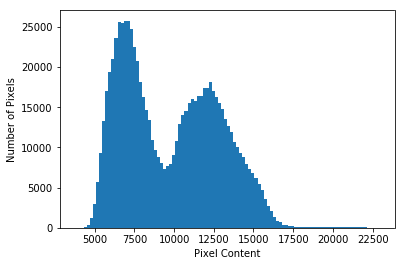

In [22]:
# Let's have a look how the pixel contents are distributed
nbins = 100
# flatten means: we put our 2d array in a 1d array
histogram = plt.hist(image_data.flatten(), nbins)

plt.xlabel('Pixel Content')
plt.ylabel('Number of Pixels')

plt.show()

#### Plot Skymaps

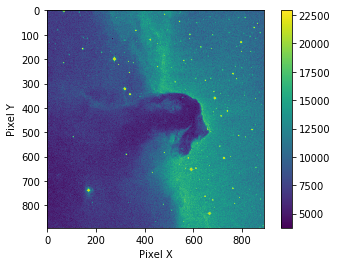

In [23]:
# A simple plot of the image
plt.imshow(image_data)

plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

plt.colorbar()

plt.show()

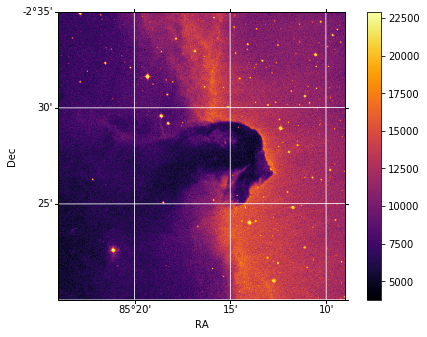

In [24]:
fig = plt.figure()

wcs = WCS(image_header)
ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
fig.add_axes(ax)

img = ax.imshow(image_data, cmap='inferno')

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

ax.grid(color='white', ls='solid')
fig.colorbar(img)

plt.show()

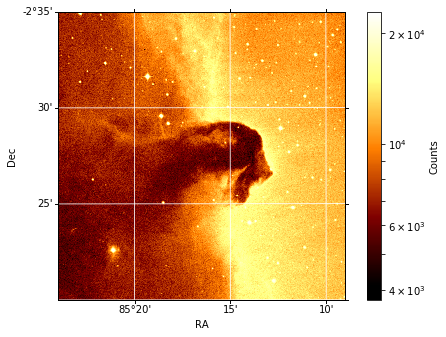

In [25]:
fig = plt.figure()

wcs = WCS(image_header)
ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
fig.add_axes(ax)

# Now with an other colormap and in logscale
img = ax.imshow(image_data, cmap='afmhot', norm=LogNorm())

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

ax.grid(color='white', ls='solid')

# Set the limits of the colorbar and a label
cb = fig.colorbar(img)
cb.set_clim(1.1*np.min(image_data), np.max(image_data))
cb.set_label('Counts')

plt.show()

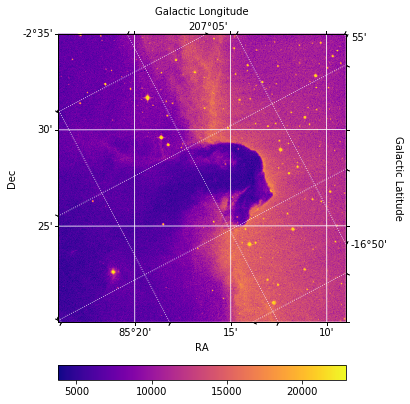

In [26]:
# Here we can specify the dimension and format of our figure
# That's often useful to fit images in a paper or talk etc.
fig = plt.figure(figsize=(4,6))

wcs = WCS(image_header)
ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
fig.add_axes(ax)

img = ax.imshow(image_data, cmap='plasma')

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

ax.grid(color='white', ls='solid')

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude')
overlay[1].set_axislabel('Galactic Latitude')

# If we use the colorbar like this, it will overlap with our new axis
# Furthermore, we specify the ticks of the colorbar
# fig.colorbar(img, ticks=[5000, 10000, 15000, 20000])

# Therefore, the anchor commad is moving the colorbar horizontally. 
# fig.colorbar(img, ticks=[5000, 10000, 15000, 20000], anchor=(1.0,0.0))

# Another alternative is to put the colorbar below the plot
fig.colorbar(img, ticks=[5000, 10000, 15000, 20000], 
             orientation='horizontal', pad=0.1)

plt.show()

#### Contours and Annotations

In [27]:
# Let's get some data form the HESS Galactic Plane Survey
urlretrieve('https://www.mpi-hd.mpg.de/hfm/HESS/hgps/data/hgps_catalog_v1.fits.gz', 
            './HGPS_Catalog.fits.gz')
urlretrieve('https://www.mpi-hd.mpg.de/hfm/HESS/hgps/data/hgps_map_significance_0.1deg_v1.fits.gz', 
            './HGPS_SignificanceMap.fits.gz')

('./HGPS_SignificanceMap.fits.gz', <http.client.HTTPMessage at 0x18206a4c88>)

In [28]:
hdu = fits.open('HGPS_SignificanceMap.fits.gz')
image_data = hdu[0].data
image_header = hdu[0].header

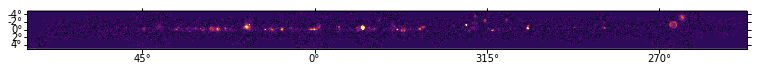

In [29]:
fig = plt.figure(figsize=(10,10))

wcs = WCS(image_header)
ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
fig.add_axes(ax)

img = ax.imshow(image_data, cmap='inferno', vmax=20)

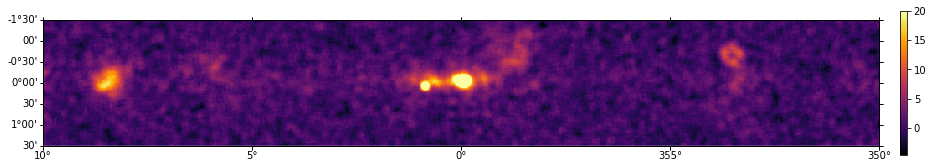

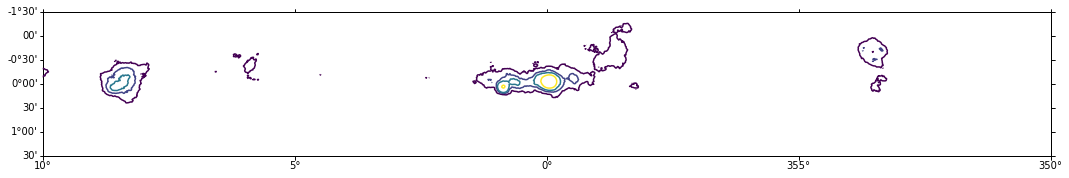

In [30]:
fig = plt.figure(figsize=(14,2))

wcs = WCS(image_header)
ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
fig.add_axes(ax)

img = ax.imshow(image_data, cmap='inferno',
               vmax=20)
fig.colorbar(img, pad=0.02)

# Crop the image. This has to be done in pixel coordinates.
# Therefore, transform Galactic coordinates to be cropped to pixel coordinates
c1 = coord.SkyCoord(l=-10*u.deg, b=-1.5*u.deg, frame='galactic').to_pixel(wcs)
c2 = coord.SkyCoord(l=10*u.deg, b=1.5*u.deg, frame='galactic').to_pixel(wcs)
ax.set_xlim(c2[0],c1[0])
ax.set_ylim(c2[1],c1[1])

plt.show()

# -- # -- #
fig = plt.figure(figsize=(14,2))
wcs = WCS(image_header)
ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
fig.add_axes(ax)

# Derive the contours
# Levels of the contours can be set by user
# By default a colormap (viridis) is used for the colors of the different levels
# If only one color is specified, all levels will have the same color
ax.contour(image_data, transform=ax.get_transform(wcs),
           levels=[5, 10, 15, 30])

ax.set_xlim(c2[0],c1[0])
ax.set_ylim(c2[1],c1[1])

plt.show()

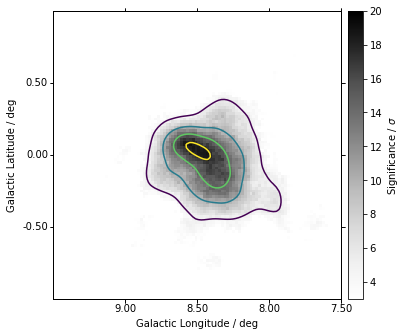

In [31]:
fig = plt.figure(figsize=(5,4))

wcs = WCS(image_header)
ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
fig.add_axes(ax)

img = ax.imshow(image_data, cmap='Greys',
               vmin=3, vmax=20)
fig.colorbar(img, pad=0.02, label='Significance / $\sigma$')

# Smooth the data first, to have more smooth contours
smooth = gaussian_filter(image_data, sigma=2)
ax.contour(smooth, transform=ax.get_transform(wcs),
           levels=[5, 10, 14, 17])

c1 = coord.SkyCoord(l=7.5*u.deg, b=-1*u.deg, frame='galactic').to_pixel(wcs)
c2 = coord.SkyCoord(l=9.5*u.deg, b=1*u.deg, frame='galactic').to_pixel(wcs)
ax.set_xlim(c2[0],c1[0])
ax.set_ylim(c2[1],c1[1])

lon = ax.coords['glon']
lat = ax.coords['glat']
lat.set_major_formatter('d.dd')
lon.set_major_formatter('d.dd')

ax.invert_yaxis()
ax.set_xlabel('Galactic Longitude / deg')
ax.set_ylabel('Galactic Latitude / deg')

plt.show()

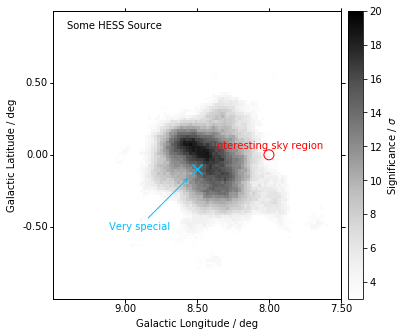

In [32]:
fig = plt.figure(figsize=(5,4))

wcs = WCS(image_header)
ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
fig.add_axes(ax)

img = ax.imshow(image_data, cmap='Greys',
               vmin=3, vmax=20)
fig.colorbar(img, pad=0.02, label='Significance / $\sigma$')

# Add a circle
ax.scatter(8, 0, transform=ax.get_transform('galactic'),
          facecolor='', edgecolor='red', s=100)

# Add a cross
ax.scatter(8.5, -0.1, marker='x', transform=ax.get_transform('galactic'),
          color='deepskyblue', s=100)

# Add some text in Galactic coordinates
ax.text(8, 0.1, 'Interesting sky region', 
        transform=ax.get_transform('galactic'),
        color='red',
       horizontalalignment='center',
       verticalalignment='top')

# Add some text in relative coordinates
ax.text(0.05, 0.95, 'Some HESS Source', 
        transform=ax.transAxes,
        color='black',
       horizontalalignment='left',
       verticalalignment='center')

# Add some text together with an arrow
ax.annotate('Very special',
            xy=(8.55, -0.15), 
            xytext=(-50, -50),
            textcoords='offset pixels',
            xycoords=ax.get_transform('galactic'),
            color='deepskyblue',
            horizontalalignment='center',
            verticalalignment='center',
            arrowprops=dict(color='deepskyblue', arrowstyle='->'),
           )


ax.set_xlim(c2[0],c1[0])
ax.set_ylim(c2[1],c1[1])

lon = ax.coords['glon']
lat = ax.coords['glat']
lat.set_major_formatter('d.dd')
lon.set_major_formatter('d.dd')

ax.invert_yaxis()
ax.set_xlabel('Galactic Longitude / deg')
ax.set_ylabel('Galactic Latitude / deg')

plt.show()